In [1]:
# 导入所需的包
import numpy as np
import pandas as pd 
import math
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold
from sklearn.datasets import make_circles
from sklearn.datasets import make_classification

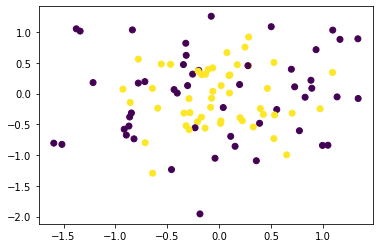

In [2]:
# 使用scikit-learn生成一个简单的二分类数据集
X, y = make_circles(n_samples=100, noise=0.5, factor=0.2, random_state=1)

# 二分类标签一般是‘0’和‘1’，adaboost算法的标签为‘1’，‘-1’，修改adaboost标签‘0’变为‘-1’
y_ada = y.copy()
y_ada[y_ada == 0] = -1

# 可视化生成的数据集
plt.scatter(X[:, 0], X[:, 1], c=y)

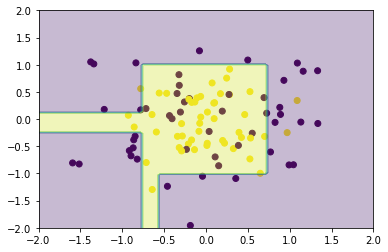

In [3]:
# 首先使用CART对数据进行训练

# 要求采用DecisionTreeClassifier构建最大深度为5，其余为默认参数的决策树模型，并使用fit方法拟合生成的(X, y)数据，采用score方法测试模型精度
cart_model = DecisionTreeClassifier(max_depth = 5)
cart_model.fit(X, y)

# 可视化CART的分类效果
x1_grid = np.linspace(-2, 2, 100)
x2_grid = np.linspace(-2, 2, 100)
x1_grid, x2_grid = np.meshgrid(x1_grid, x2_grid)
y_grid_simple = np.zeros_like(x1_grid)
X_grid = np.hstack([x1_grid.reshape(-1, 1), x2_grid.reshape(-1, 1)])

# 采用predict方法使用生成模型进行分类预测
y_grid = cart_model.predict(X_grid, check_input=True)
y_grid_simple = y_grid.reshape(100, 100)

#可视化结果
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.contourf(x1_grid, x2_grid, y_grid_simple, alpha=0.3)

In [4]:
def adaboost(X, y, M, max_depth=None):
    """
    adaboost函数，使用CART作为弱分类器
    参数:
        X: 训练样本
        y: 样本标签, y = {-1, +1}
        M: 使用M个弱分类器
        max_depth: 基学习器CART决策树的最大深度
    返回:
        F: 生成的模型
    """
    num_X, num_feature = X.shape
    
    ### START CODE HERE ###
    # 初始化训练数据的权值分布
    D = np.ones(num_X)/num_X
    G = []
    alpha = []
    for m in range(M):
        # 使用具有权值分布D_m的训练数据集学习，得到基本分类器
        # 使用DecisionTreeClassifier，设置树深度为max_depth
        G_m = DecisionTreeClassifier(max_depth=max_depth)
        # 开始训练(需要给参数sample_weight赋值)
        G_m.fit(X,y,D)
        # 计算G_m在训练数据集上的分类误差率
        y_pred = G_m.predict(X)
        e_m = np.sum(D[y!=y_pred])
        if e_m == 0:
            break
        if e_m == 1:
            raise ValueError("e_m = {}".format(e_m))
        # 计算G_m的系数
        alpha_m = 0.5*np.log((1-e_m)/e_m)
        # 更新训练数据集的权值分布
        D = np.multiply(D,np.exp(-1*alpha_m*y*y_pred))
        D = D/np.sum(D)
        # 保存G_m和其系数
        G.append(G_m)
        alpha.append(alpha_m)
    
    # 构建基本分类器的线性组合
    def F(X):
        num_G = len(G)
        score = 0
        for i in range(num_G):
            score += alpha[i]*G[i].predict(X)
        return np.sign(score)
    ### END CODE HERE ###
    
    return F

In [7]:
def sigmoid(x):
    """
    计算sigmoid函数值
    """
    return 1 / (1 + np.exp(-x))

def gbdt_classifier(X, y, M, max_depth=None):
    """
    用于分类的GBDT函数
    参数:
        X: 训练样本
        y: 样本标签，y = {0, +1}
        M: 使用M个回归树
        max_depth: 基学习器CART决策树的最大深度
    返回:
        F: 生成的模型
    """
    ### START CODE HERE ###
    # 用0初始化y_reg
    y_reg = np.zeros(len(y))
    f = []
    
    for m in range(M):
        # 计算r
        r = y-sigmoid(y_reg)
        # 拟合r
        # 使用DecisionTreeRegressor，设置树深度为5，random_state=0
        f_m = DecisionTreeRegressor(max_depth=5,random_state=0)
        # 开始训练
        f_m.fit(X,r)
        # 更新f
        f.append(f_m)
        y_reg += f_m.predict(X)
    
    def F(X):
        num_X, _ = X.shape
        reg = np.zeros((num_X))
        for t in f:
            reg += t.predict(X)
        y_pred_gbdt = sigmoid(reg)
        # 以0.5为阈值，得到最终分类结果0或1
        one_position = y_pred_gbdt>=0.5
        y_pred_gbdt[one_position] = 1
        y_pred_gbdt[~one_position] = 0
        return y_pred_gbdt
    
    ### END CODE HERE ###
    return F

Accuracy of Adaboost model is 1.0
Accuracy of GBDT model is 0.97


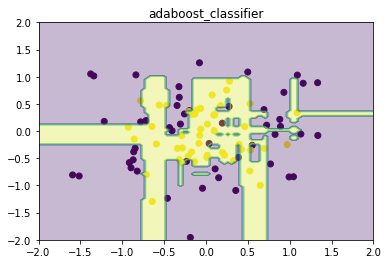

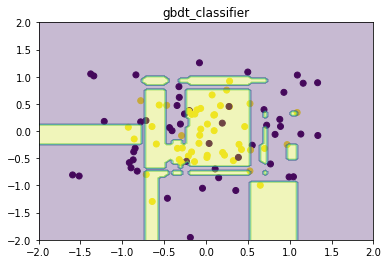

In [8]:
# 用adaboost和GBDT模型进行训练

adaboost_model = adaboost(X, y_ada, 10, max_depth=5)
gbdt_model = gbdt_classifier(X, y, 10, max_depth=5)

y_pre_ada = adaboost_model(X)
y_pre_gbdt = gbdt_model(X)

accuracy_ada = np.mean(y_pre_ada == y_ada)
accuracy_gbdt = np.mean(y_pre_gbdt == y)

print("Accuracy of Adaboost model is {}".format(accuracy_ada))
print("Accuracy of GBDT model is {}".format(accuracy_gbdt))

# 可视化CART的分类效果
x1_grid = np.linspace(-2, 2, 100)
x2_grid = np.linspace(-2, 2, 100)

x1_grid, x2_grid = np.meshgrid(x1_grid, x2_grid)
X_grid = np.hstack([x1_grid.reshape(-1, 1), x2_grid.reshape(-1, 1)])

y_grid_ada = adaboost_model(X_grid)
y_grid_gbdt = gbdt_model(X_grid)

y_grid_simple_ada = y_grid_ada.reshape(100, 100)
y_grid_simple_gbdt = y_grid_gbdt.reshape(100, 100)

ada_fig=plt.figure()
ax1=ada_fig.add_subplot(111)
ax1.set_title('adaboost_classifier')
ax1.scatter(X[:, 0], X[:, 1], c=y_ada)
ax1.contourf(x1_grid, x2_grid, y_grid_simple_ada, alpha=0.3)

gbdt_fig=plt.figure()
ax2=gbdt_fig.add_subplot(111)
ax2.set_title('gbdt_classifier')
ax2.scatter(X[:, 0], X[:, 1], c=y)
ax2.contourf(x1_grid, x2_grid, y_grid_simple_gbdt, alpha=0.3)

plt.show()

In [9]:
def bagging(X, y, T, size, seed=0, max_depth=None):
    """
    Bagging算法，分类器为CART，用于二分类
    参数：
        X: 训练集
        y: 样本标签
        T: T组
        size: 每组训练集的大小
        seed: 随机种子
        max_depth: 基学习器CART决策树的最大深度
    返回：
        F: 生成的模型
    """
    classifiers = []
    m, n = X.shape
    
    ### START CODE HERE ###
    np.random.seed(seed)
    for i in range(T):
        # 使用np.random.choice选择size个序号，注意replace参数的设置，以满足有放回的均匀抽样。
        index = np.random.choice(m,size)
        X_group = X[index]
        y_group = y[index]
        # 使用tree.DecisionTreeClassifier，设置max_depth=max_depth, min_samples_split=2(生成完全树),random_state=0
        t = DecisionTreeClassifier(max_depth=max_depth,min_samples_split=2,random_state=0)
        # 开始训练
        t.fit(X_group,y_group)
        classifiers.append(t)
        
    def F(X):
        # 计算所有分类器的预测结果
        result = []
        for t in classifiers:
            result.append(t.predict(X))
        # 把预测结果组成 num_X * T 的矩阵
        pred = np.vstack(result).T
        # 计算"0"有多少投票
        vote_0 = T-np.sum(pred,axis=1)
        # 计算"1"有多少投票
        vote_1 = T-vote_0
        # 选择投票数最多的一个标签
        pred = (vote_1>vote_0).astype(int)
        return pred     
    ### END CODE HERE ###
    
    return F

In [10]:
data_train = pd.read_csv("./titanic/train.csv")

### START CODE HERE ###
# 采用mean()得到年龄均值，填补缺失信息
average_age = data_train['Age'].mean()
data_train.loc[(data_train.Age.isnull()), 'Age' ] = average_age

# 采用pd.get_dummies得到离散数据(使用pd.get_dummies())
dummies_Embarked = pd.get_dummies(data_train['Embarked'])
dummies_Sex = pd.get_dummies(data_train['Sex'])
dummies_Pclass = pd.get_dummies(data_train['Pclass'])

### END CODE HERE ###
# 采用pd.oncat合并原始数据和生成的离散数据
df = pd.concat([data_train, dummies_Embarked, dummies_Sex, dummies_Pclass], axis=1)
df['family_num'] = df['SibSp'].values + df['Parch'].values

# 得到最终的训练数据的字段
train_df = df.filter(regex='Survived|Age.*|family_num|Fare.*|Cabin_.*|Embarked_.*|Sex_.*|Pclass.*')
# 显示最终处理完成的数据信息
print(train_df.info())

train_np = np.array(train_df)
print(train_np.shape)


# y即Survival结果
y = train_np[:, 0]

# X即特征属性值
X = train_np[:, 1:]

print(X.shape)
print(y.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    int64  
 1   Pclass      891 non-null    int64  
 2   Age         891 non-null    float64
 3   Fare        891 non-null    float64
 4   family_num  891 non-null    int64  
dtypes: float64(2), int64(3)
memory usage: 34.9 KB
None
(891, 5)
(891, 4)
(891,)


In [11]:
n_splits = 5
kf = KFold(n_splits)
accuracy_train_ada, accuracy_val_ada = 0, 0
accuracy_train_gbdt, accuracy_val_gbdt = 0, 0
accuracy_train_rf, accuracy_val_rf = 0, 0
accuracy_train_CART, accuracy_val_CART = 0, 0

for train, test in kf.split(X):
    X_train, X_test, y_train, y_test = X[train], X[test], y[train], y[test]
    y_train_ada = y_train.copy()
    y_train_ada[y_train_ada == 0] = -1
    y_test_ada = y_test.copy()
    y_test_ada[y_test_ada == 0] = -1
    
    adaboost_model = adaboost(X_train, y_train_ada, 100, max_depth=10)
    gbdt_model = gbdt_classifier(X_train, y_train, 100, max_depth=10)
    randomforest_model = bagging(X_train, y_train, 100, int(X_train.shape[0]*0.4), max_depth=10)
    CART = DecisionTreeClassifier(max_depth=10)
    CART.fit(X_train, y_train)
    
    y_train_pre_ada = adaboost_model(X_train)
    y_test_pre_ada = adaboost_model(X_test)
    y_train_pre_gbdt = gbdt_model(X_train)
    y_test_pre_gbdt = gbdt_model(X_test)
    y_train_pre_rf = randomforest_model(X_train)
    y_test_pre_rf = randomforest_model(X_test)
 
    accuracy_train_CART += CART.score(X_train, y_train)
    accuracy_val_CART += CART.score(X_test, y_test)
    accuracy_train_ada += np.mean(y_train_pre_ada == y_train_ada)
    accuracy_val_ada += np.mean(y_test_pre_ada == y_test_ada)
    accuracy_train_gbdt += np.mean(y_train_pre_gbdt == y_train)
    accuracy_val_gbdt += np.mean(y_test_pre_gbdt == y_test)
    accuracy_train_rf += np.mean(y_train_pre_rf == y_train)
    accuracy_val_rf += np.mean(y_test_pre_rf == y_test)
    
    
print("Accuracy of cart model in trainset is {}, in validation set is {}".format(accuracy_train_CART/n_splits, accuracy_val_CART/n_splits))
print("Accuracy of adaboost model in trainset is {}, in validation set is {}".format(accuracy_train_ada/n_splits, accuracy_val_ada/n_splits))
print("Accuracy of gbdt model in trainset is {}, in validation set is {}".format(accuracy_train_gbdt/n_splits, accuracy_val_gbdt/n_splits))
print("Accuracy of random forest model in trainset is {}, in validation set is {}".format(accuracy_train_rf/n_splits, accuracy_val_rf/n_splits))

Accuracy of cart model in trainset is 0.8566253526009738, in validation set is 0.6577051032577993
Accuracy of adaboost model in trainset is 0.9590348582504689, in validation set is 0.6621869311405436
Accuracy of gbdt model in trainset is 0.9399550089036671, in validation set is 0.6767748415039859
Accuracy of random forest model in trainset is 0.840629087413524, in validation set is 0.7004142866110099
